# About

This notebook is for the seminar 2. Here you will find tasks and all necessary information to complete them.

In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

## Generate events

This section shows how data sample with 2D straight track can be generated. The data sample consist of number of events. Each event is a set of hits. Some of the hits form track, but some of them are just noise hits.  

For the events generation a **straight_tracks_generator** function is used.

Parameters of the function:

**n_events**: int, number of generated events.

**n_tracks**: int, number of generated tracks in each event. Tracks will have TrackIDs in range [0, inf).

**n_noise**: int, number of generated random noise hits. Noise hits will have TrackID -1.

**sigma**: float, track's hit generated with error which has normal distribution.
              Sigma is parameter of the distribution.
              
**intersection**: booleen, if False the tracks will not intersect each other.

**x_range**: tuple (min, max, step), range of x values of the hits.

**y_range**: tuple (min, max, step), range of y values of the hits. Only for intersection=False.

**k_range**: tuple (min, max, step), range of k values of the track. y = b + k * x.

**b_range**: tuple (min, max, step), range of b values of the track. y = b + k * x.

In [2]:
from utils import straight_tracks_generator
events = straight_tracks_generator(n_events=10, n_tracks=3, n_noise=5, sigma=0.01, x_range=(0, 10, 1), intersection=False, y_range=(0, 10, 1))

events.head()

,EventID,TrackID,X,y
0,0,0,0,0.989907
1,0,0,1,1.109944
2,0,0,2,1.222444
3,0,0,3,1.344984
4,0,0,4,1.458528


## Plot Tracks

Function **plot_straight_tracks** generates plot of an event with its tracks and noise hits.

Parameters of the function:

**event**: pandas.DataFrame with one event.

**labels**: numpy.array shape=[n_hits], labels of recognized tracks.

**return**: matplotlib.pyplot object.

In [3]:
event = events[events.EventID == 0]
X = event.X.values
y = event.y.values

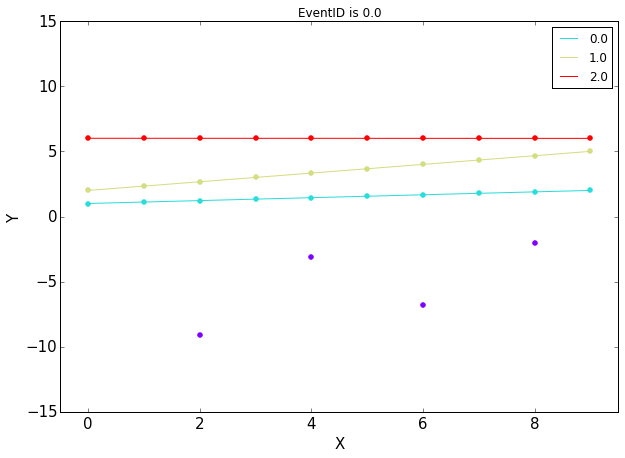

In [4]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels=None)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

## Tracks Recognition

## Rotor Model

The first task is to realize a rotor model for the track pattern recognition.

Finish the following class below. Run it. Play with it!

In [128]:
from seminars_utils import rotors2states, cut_neurons, find_tracks, cut_labels

class RotorModel(object):

    def __init__(self, n_iter, alpha, degree, temperature, min_rotor_cos, max_states_cos, min_hits):
        """
        This class is realization of the rotor model of the tracks recognition.
        :param n_iter: int, number of iterations.
        :param alpha: float, penalty for the large angle between a rotor and a vector between two hits in the energy function.
        :param degree: int, degree of distance between two hits.
        :param temperature: float, temperature in update rule.
        :param min_rotor_cos: float, min abs value of cos of angle between a rotor of a hit and the vector between of the two hits.
        If the cos less than this value, the link between the hits refused.
        :param max_states_cos: float, if cos between two neurons is less than this value, the rotors are from the same track.
        :param min_hits: int, tracks with number of hits larger then min_hits considered as a track candidate.
        :return:
        """

        self.n_iter = n_iter
        self.alpha = alpha
        self.temperature = temperature
        self.degree = degree
        self.min_rotor_cos = min_rotor_cos
        self.max_states_cos = max_states_cos
        self.min_hits = min_hits

        self.dist_ = None
        self.radiu_ = None
        self.rotors_ = None

        self.energy_stages_ = []
        self.rotor_stages_ = []

    def r_modules(self, x, y):
        """
        This method calculates distances between each pair of hits.
        :param x: numpy.array, shape = [n_hits], x-coordinates of the hits.
        :param y: numpy.array, shape = [n_hits], y-coordinates of the hits.
        :return: numpy.ndarray, shape = [n_hirs, n_hirs]
        """

        # Change the following code by the correct one. Inputs and outputs are the same.
        # dist = numpy.random.rand(len(x), len(x))
        
        n_hits = len(x)

        dist = numpy.zeros((n_hits, n_hits))

        for i in range(n_hits):

            for j in range(n_hits):

                dist[i, j] = numpy.array((x[i] - x[j])**2 + (y[i] - y[j])**2)

        return dist

    def r_vectors(self, x, y):
        """
        This method calculates coordinates of vectors between each pair of hits.
        :param x: numpy.array, shape = [n_hits], x-coordinates of the hits.
        :param y: numpy.array, shape = [n_hits], y-coordinates of the hits.
        :return: numpy.ndarray, shape = [n_hirs, n_hirs, 2]
        """
        
        # Change the following code by the correct one. Inputs and outputs are the same.
        # radius = numpy.random.rand(len(x), len(x), 2)

        n_hits = len(x)

        radius = numpy.zeros((n_hits, n_hits, 2))

        for i in range(n_hits):

            for j in range(n_hits):

                vector = numpy.array([x[j] - x[i], y[j] - y[i]])
                radius[i, j] = vector

        return radius

    def energy(self, rotor, dist, radius):
        """
        This method calculates energy of while system.
        :param rotor: numpy.ndarray, shape = [n_hits, 2], rotors of the hits.
        :param dist: numpy.ndarray, shape = [n_hirs, n_hirs], distances between each pair of hits.
        :param radius: numpy.ndarray, shape = [n_hirs, n_hirs, 2], coordinates of vectors between each pair of hits.
        :return: float
        """
        
        # Change the following code by the correct one. Inputs and outputs are the same.
        # E = numpy.random.rand(1)[0]

        n_hits = len(rotor)

        E = 0

        for i in range(n_hits):

            for j in range(n_hits):

                if i==j:
                    continue

                E += -0.5 * 1. / dist[i,j]**self.degree * numpy.inner(rotor[i], rotor[j]) \
                     -0.5 * self.alpha * 1. / dist[i,j]**self.degree * (numpy.inner(rotor[i], radius[i,j]))**2

        return E

    def energy_derivative(self, rotor, dist, radius):
        """
        This method calculates derivative of the energy of while system.
        :param rotor: numpy.ndarray, shape = [n_hits, 2], rotors of the hits.
        :param dist: numpy.ndarray, shape = [n_hirs, n_hirs], distances between each pair of hits.
        :param radius: numpy.ndarray, shape = [n_hirs, n_hirs, 2], coordinates of vectors between each pair of hits.
        :return: float
        """
        
        # Change the following code by the correct one. Inputs and outputs are the same.
        # dE = numpy.random.rand(1)[0]

        n_hits = len(rotor)

        dE = numpy.zeros((n_hits, 2))

        for i in range(n_hits):

            for j in range(n_hits):

                if i==j:
                    continue

                dE[i] += -0.5 * 1. / dist[i,j]**self.degree * rotor[j] \
                     -1. * self.alpha * 1. / dist[i,j]**self.degree * (numpy.inner(rotor[i], radius[i,j])) * radius[i,j]

        return dE

    def rotors2labels(self, x, y, rotor, min_rotor_cos, max_states_cos):
        """
        This method transform rotors to labels of the hits.
        :param x: numpy.array, shape = [n_hits], x-coordinates of the hits.
        :param y: numpy.array, shape = [n_hits], y-coordinates of the hits.
        :param rotor: numpy.ndarray, shape = [n_hits, 2], rotors of the hits.
        :param min_rotor_cos: float, min abs value of cos of angle between a rotor of a hit and the vector between of the two hits.
        If the cos less than this value, the link between the hits refused.
        :param max_states_cos: float, if cos between two neurons is less than this value, the rotors are from the same track. 
        :return: numpy.array, shape = [n_hits]; numpy.ndarray, shape = [n_hits, n_hits]
        """
        
        # You can code you own method.

        states = rotors2states(x, y, rotor, min_rotor_cos)
        cut_states = cut_neurons(x, y, states, max_states_cos, 0.5)
        labels = find_tracks(cut_states, 0.5)
        cutted_labels = cut_labels(labels, min_hits=self.min_hits)

        return cutted_labels, cut_states


    def fit(self, x, y):
        """
        This method runs the rotor model.
        :param x: numpy.array, shape = [n_hits], x-coordinates of the hits.
        :param y: numpy.array, shape = [n_hits], y-coordinates of the hits. 
        :return:
        """

        n_hits = len(x)

        dist = self.r_modules(x, y)
        self.dist_ = dist

        radius = self.r_vectors(x, y)
        self.radius_ = radius

        rotor = numpy.random.rand(n_hits, 2)
        self.rotor_ = rotor

        E = self.energy(rotor, dist, radius)
        dE = self.energy_derivative(rotor, dist, radius)

        self.energy_stages_.append(E)
        self.rotor_stages_.append(rotor)

        for one_iter in range(self.n_iter):

            # Code update rule of the rotors.
            
            dE = self.energy_derivative(rotor, dist, radius)
            rotor = numpy.tanh(- dE / self.temperature)

            E = self.energy(rotor, dist, radius)

            self.energy_stages_.append(E)
            self.rotor_stages_.append(rotor)


        self.labels_, self.cut_states_ = self.rotors2labels(x, y, rotor, self.min_rotor_cos, self.max_states_cos)
        self.rotor_ = rotor


In [129]:
rm = RotorModel(n_iter=20, alpha=1., temperature=1.0, degree=4.0, min_rotor_cos=0.8, max_states_cos=-0.9, min_hits=3)
rm.fit(X, y)

dist = rm.dist_
radius = rm.radius_
rotor = rm.rotor_
labels = rm.labels_

energies = rm.energy_stages_

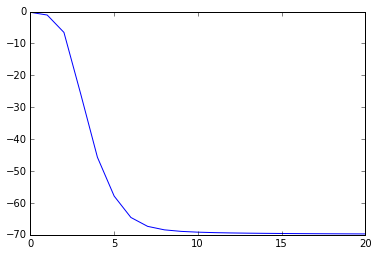

In [130]:
plt.plot(energies)
plt.show()

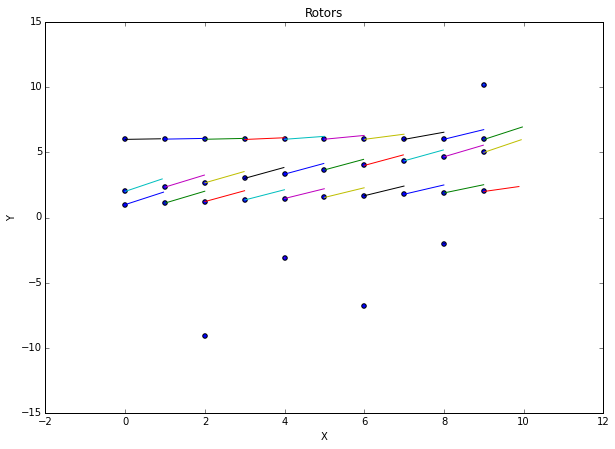

In [136]:
plt.figure(figsize=(10,7))
plt.scatter(X,y)

for i in range(len(X)):
    
    plt.plot(numpy.array([X[i], X[i]+rotor[i, 0]]), numpy.array([y[i], y[i]+rotor[i, 1]]))
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Rotors')
plt.show()

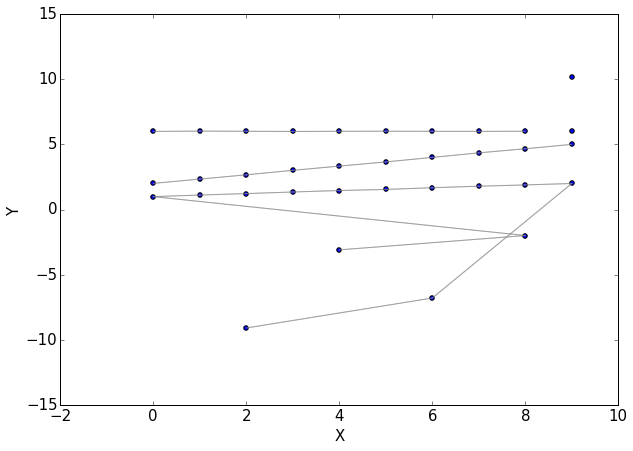

In [125]:
from DenbyPeterson import plot_neural_net

plot_neural_net(X, y, states, 0.5)
plt.show()

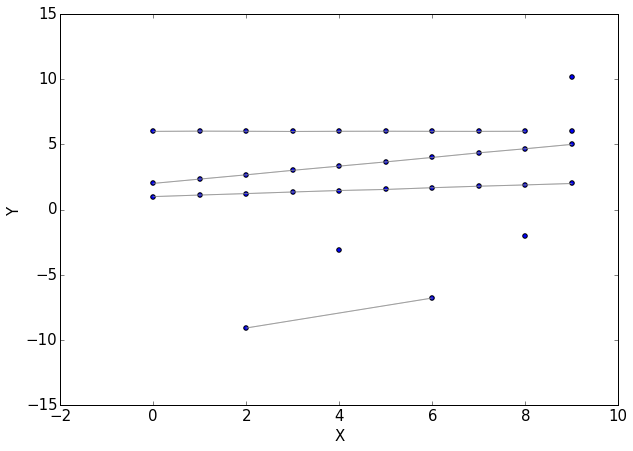

In [126]:
plot_neural_net(X, y, cut_states, 0.5)
plt.show()

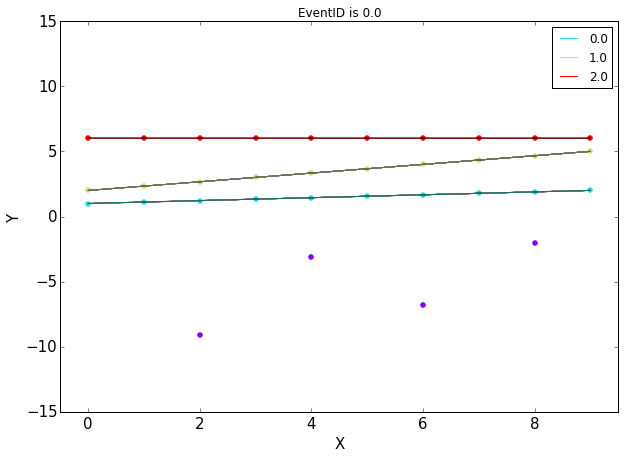

In [127]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

## Hough Transform

The first task is to realize the Linear Hough Transfrom model for the track pattern recognition.

Finish the following class below. Run it. Play with it!

In [110]:
class LinearHoughModel(object):

    def __init__(self, k_params=(-2, 2, 0.1), b_params=(-10, 10, 1), min_hits=4):
        """
        This calss is realizarion of the Linear Hough Transform method for the track recognition.
        :param k_params: tuple (min, max, step), bins parameters for the k parameter.
        :param b_params: tuple (min, max, step), bins parameters for the b parameter.
        :param min_hits: int, tracks with number of hits larger then min_hits considered as a track candidate.
        :return:
        """

        self.k_params = k_params
        self.b_params = b_params
        self.min_hits = min_hits

        self.labels_ = None

    def linear_hough(self, x_hit, y_hit, k_params, b_params):
        """
        This method do Hough Transform just for one point.
        :param x_hit: float, x-coordinate of a hit. y = kx + b.
        :param y_hit: float, y-coordinate of a hit. y = kx + b.
        :param k_params: tuple (min, max, step), bins parameters for the k parameter.
        :param b_params: tuple (min, max, step), bins parameters for the b parameter.
        :return: numpy.array; numpy.array.
        """

        # y = kx+b -> b = y - kx
        
        # Change the following code by the correct one. Inputs and outputs are the same.
        # k = numpy.random.rand(100)
        # b = numpy.random.rand(100)
        
        n_points = 10. * (k_params[1] - k_params[0]) / (k_params[2])

        k = numpy.arange(*k_params)
        b = y_hit - k * x_hit

        return k, b

    def get_hits(self, hists, max_ind):
        """
        This method finds hits that corresponding cell of histogram with max counts.
        :param hists: list of histograms for each hit.
        :param max_ind: tuple (int, int), index of the cell with max counts.
        :return: list of indeces of the hits.
        """
        
        # Change the following code by the correct one. Inputs and outputs are the same.
        # hits = numpy.random.randint(0, len(hists), 3)

        hits = []

        for ind, hit_hist in enumerate(hists):

            if hit_hist[max_ind] == 1:

                hits.append(ind)

        return hits


    def fit(self, x, y):
        """
        This method runs the Linear Hough Transfrom method.
        :param x: numpy.array, shape = [n_hits], x-coordinates of the hits.
        :param y: numpy.array, shape = [n_hits], y-coordinates of the hits.
        :return:
        """
        
        # Finish the function. Inputs and outputs are the same.

        n_hits = len(x)
        labels = -1. * numpy.ones(n_hits)

        track_id = 0

        hists = []
        n_k = (self.k_params[1] - self.k_params[0]) / (self.k_params[2])
        n_b = (self.b_params[1] - self.b_params[0]) / (self.b_params[2])

        for hit_id in range(n_hits):

            x_hit = x[hit_id]
            y_hit = y[hit_id]

            k_hit, b_hit = self.linear_hough(x_hit, y_hit, self.k_params, self.b_params)

            (hit_hist, xedges, yedges) = numpy.histogram2d(k_hit, b_hit, range=[[self.k_params[0], self.k_params[1]],
                                                            [self.b_params[0], self.b_params[1]]],
                                                         bins=[n_k, n_b])
            hit_hist = (hit_hist > 0) * 1.
            hists.append(hit_hist)

        hists = numpy.array(hists)
        total_hist = hists.sum(axis=0)

        while total_hist.max() >= self.min_hits:

            total_hist = hists[labels == -1].sum(axis=0)
            max_ind = numpy.unravel_index(numpy.argmax(total_hist), total_hist.shape)

            hits = self.get_hits(hists, max_ind)

            if len(hits) >= self.min_hits:

                labels[hits] = track_id
                track_id += 1


        self.labels_ = labels

In [119]:
lh = LinearHoughModel(k_params=(-2, 2, 0.1), b_params=(-10, 10, 1), min_hits=4)
lh.fit(X, y)
labels = lh.labels_

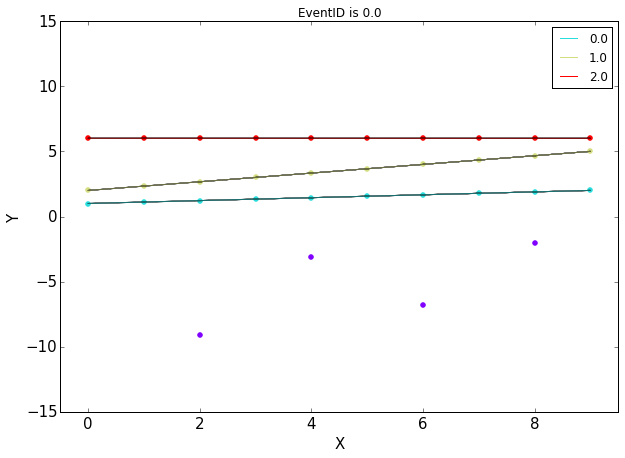

In [120]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()